# Covid-19: From model prediction to model predictive control

## JPGMs tryout of the QALY calculation

*Original code by Juan Pablo Gallo. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by BIOMATH, Ghent University. All Rights Reserved.

This notebook contains a demo calculation of the number of *Quality adjusted life years* lost due to COVID-19. The calculation is performed ex-post simulation. The calculation is a simple manipulation of the number of predicted deaths. 

For this demo, the deterministic national-level model was used. All details with regard to the model can be found in our preprint *A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*, which can be found here: https://www.medrxiv.org/content/10.1101/2020.07.17.20156034v2

In [1]:
import gc
import sys, getopt
import ujson as json
import random
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Load the covid 19 custom development code

In [2]:
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters, VOC
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 

In [3]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [4]:
# --------------------------
# Define simulation settings
# --------------------------

N=10
k=1
# Start and end of simulation
start_sim = '2020-09-01'
end_sim = '2021-09-01'
# Confidence level used to visualise model fit
conf_int = 0.05
# Path where figures and results should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/others/WAVE2/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

## Model initialization

In [5]:
# -----------------------
# Load samples dictionary
# -----------------------

from covid19model.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+'BE_WAVE2_R0_COMP_EFF_'+'2021-05-28'+'.json', wave=2)
warmup = int(samples_dict['warmup'])

# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Sciensano public data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Sciensano mortality data
df_sciensano_mortality =sciensano.get_mortality_data()
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()
# VOC data
df_VOC_501Y = VOC.get_501Y_data()
# Start of data collection
start_data = df_sciensano.idxmin()
# Start of calibration warmup and beta
start_calibration = samples_dict['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict['end_calibration']

# ---------------------------
# Time-dependant VOC function
# ---------------------------

from covid19model.models.time_dependant_parameter_fncs import make_VOC_function
VOC_function = make_VOC_function(df_VOC_501Y)

# -----------------------------------
# Time-dependant vaccination function
# -----------------------------------

from covid19model.models.time_dependant_parameter_fncs import  make_vaccination_function
vacc_strategy = make_vaccination_function(df_sciensano)

# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, delayed_ramp_fun, ramp_fun
contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)
policies_WAVE2_full_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_full_relaxation
    
# ---------------------------------------------------
# Function to add poisson draws and sampling function
# ---------------------------------------------------

from covid19model.models.utils import output_to_visuals,draw_fcn_WAVE2

# --------------------
# Initialize the model
# --------------------

# Model initial condition on September 1st
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)    
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(vaccination=True)
# Add the time-dependant parameter function arguments
# Social policies
params.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5, 'prev_home': 0.5, 'relaxdate': '2021-06-01', 'l_relax': 31})
# VOC
params.update({'t_sig': '2021-07-01'})
# Vaccination
params.update(
    {'vacc_order': np.array(range(9))[::-1], 'daily_dose': 55000,
     'refusal': 0.2*np.ones(9), 'delay': 20}
)
# Initialize model
model = models.COVID19_SEIRD_vacc(initial_states, params,
                        time_dependent_parameters={'Nc': policies_WAVE2_full_relaxation, 'N_vacc': vacc_strategy, 'alpha':VOC_function})


## Perform simulation

In [6]:
# -------------------
# Perform simulations
# -------------------

print('\n1) Simulating COVID-19 SEIRD '+str(N)+' times')
start_sim = start_calibration
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=N,draw_fcn=draw_fcn_WAVE2,samples=samples_dict)
simtime, df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'ICU', 'D', 'R'], N, k, LL = conf_int/2, UL = 1 - conf_int/2)


1) Simulating COVID-19 SEIRD 10 times


## Visualize the total number of patients in the hospital and the predicted number of deaths in the hospital

2) Visualizing fit on deaths


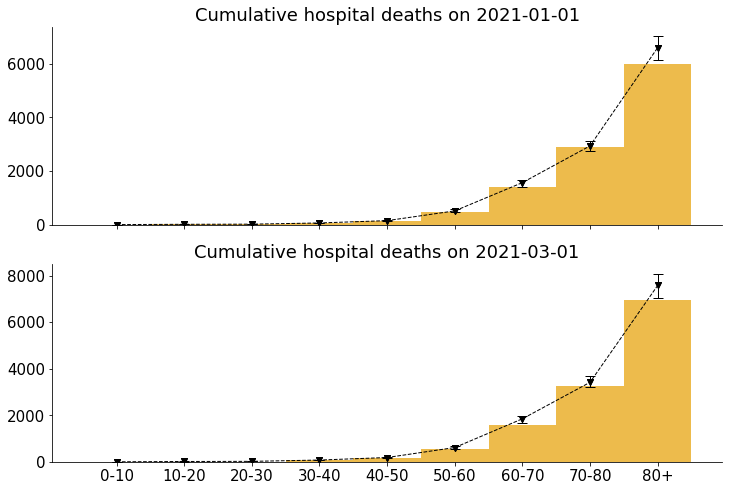

In [7]:
print('2) Visualizing fit on deaths')

dates = ['2021-01-01','2021-03-01']

fig,axes = plt.subplots(nrows=len(dates),ncols=1,figsize=(12,4*len(dates)),sharex=True)
for idx,date in enumerate(dates):
    data_sciensano = []
    for jdx,age_group in enumerate(df_sciensano_mortality.index.get_level_values(0).unique().values[1:]):
        data_sciensano.append(df_sciensano_mortality.xs(key=age_group, level="age_class", drop_level=True).loc[dates[idx]]['hospital','cumsum'])
    
    axes[idx].scatter(df_sciensano_mortality.index.get_level_values(0).unique().values[1:],out['D'].mean(dim='draws').loc[dict(time=date)],color='black',marker='v',zorder=1)
    yerr = np.zeros([2,len(out['D'].quantile(dim='draws',q=0.975).loc[dict(time=date)].values)])
    yerr[0,:] = out['D'].mean(dim='draws').loc[dict(time=date)] - out['D'].quantile(dim='draws',q=0.025).loc[dict(time=date)].values
    yerr[1,:] = out['D'].quantile(dim='draws',q=0.975).loc[dict(time=date)].values - out['D'].mean(dim='draws').loc[dict(time=date)]
    axes[idx].errorbar(x=df_sciensano_mortality.index.get_level_values(0).unique().values[1:],
                       y=out['D'].mean(dim='draws').loc[dict(time=date)],
                       yerr=yerr,
                       color = 'black', fmt = '--v', zorder=1, linewidth=1, ecolor='black', elinewidth=1, capsize=5)
    axes[idx].bar(df_sciensano_mortality.index.get_level_values(0).unique().values[1:],data_sciensano,width=1,alpha=0.7,zorder=0)
    axes[idx].set_title('Cumulative hospital deaths on '+date)
    axes[idx].grid(False)
plt.show()

## Comorbidity QALY calculations

In [8]:
# Obtain the number of QALYs that would be lost if a person of a given age dies
from covid19model.models.QALY import *

### Define the comorbidity profile of the studied population

In [9]:
# Implement the comorbidity distribution for coronavirus patients, depending on the disease outcome
# For now, the estimates by Harrison et. al 2020 are applied uniformly in every group
# Ideally, we'd use data by sciensano for this
######################################################################################

columns = [['R','R','R','R','D','D','D','D',],['0','1','2','3+','0','1','2','3+']]
tuples = list(zip(*columns))
columns = pd.MultiIndex.from_tuples(tuples, names=["population", "CCI"])
comorbidity_distribution = pd.DataFrame(index=['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+'], columns=columns)
comorbidity_distribution.index.name = 'age_group'
for idx,key in enumerate(comorbidity_distribution.index):
    comorbidity_distribution.loc[key]['R'] = [0.614, 0.174, 0.076, 0.137]
    comorbidity_distribution.loc[key]['D'] = [0.173, 0.161, 0.144, 0.522]

In [10]:
comorbidity_distribution

population      R                           D                     
CCI             0      1      2     3+      0      1      2     3+
age_group                                                         
0-9         0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
10-19       0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
20-29       0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
30-39       0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
40-49       0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
50-59       0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
60-69       0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
70-79       0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522
80+         0.614  0.174  0.076  0.137  0.173  0.161  0.144  0.522

### Initialize the QALY_model object

In [11]:
QALY_model = QALY_model(comorbidity_distribution)

In [12]:
QALY_model.QoL_Van_Wilder

,0,1,2,3+
0-9,0.890,0.880,0.760,0.720
10-19,0.890,0.880,0.760,0.720
20-29,0.900,0.860,0.775,0.690
30-39,0.910,0.840,0.790,0.660
40-49,0.895,0.845,0.785,0.655
50-59,0.880,0.850,0.780,0.650
60-69,0.870,0.845,0.785,0.640
70-79,0.860,0.840,0.790,0.630
80+,0.860,0.840,0.790,0.630


In [13]:
QALY_model.QoL_df

,group_limit,Belgium,R,D
0-9,9,0.850,0.85598,0.78093
10-19,19,0.850,0.85598,0.78093
20-29,29,0.840,0.85567,0.76594
30-39,39,0.830,0.85536,0.75095
40-49,49,0.805,0.845955,0.74583
50-59,59,0.780,0.83655,0.74071
60-69,69,0.750,0.82855,0.733675
70-79,79,0.720,0.82055,0.72664
80+,110,0.720,0.82055,0.72664


In [14]:
QALY_model.SMR_pop_df

,0,1,2,3+
0-9,0.692866,1.004656,1.455019,2.106313
10-19,0.692866,1.004656,1.455019,2.106313
20-29,0.649756,0.942146,1.364487,1.975257
30-39,0.611696,0.886959,1.284561,1.859555
40-49,0.551455,0.799610,1.158056,1.676425
50-59,0.502017,0.727924,1.054235,1.526130
60-69,0.458274,0.664498,0.962376,1.393154
70-79,0.421544,0.611239,0.885242,1.281493
80+,0.421544,0.611239,0.885242,1.281493


In [15]:
QALY_model.SMR_df

,group_limit,Belgium,R,D
0-9,9,1,0.999376,1.590634
10-19,19,1,0.999376,1.590634
20-29,29,1,0.937195,1.491664
30-39,39,1,0.882298,1.404288
40-49,49,1,0.795408,1.265993
50-59,59,1,0.724099,1.152494
60-69,69,1,0.661006,1.052074
70-79,79,1,0.608026,0.967751
80+,110,1,0.608026,0.967751


### Compute and visualize survival functions and life expectancy

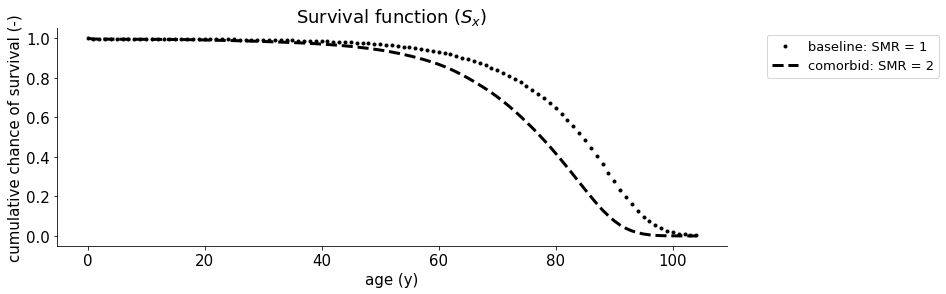

In [16]:
fig,ax = plt.subplots(figsize=(12,4))
SMR_comorbid=2
ax.set_title('Survival function ($S_x$)')
ax.set_ylabel('cumulative chance of survival (-)')
ax.set_xlabel('age (y)')
ax.plot(QALY_model.survival_function(SMR=1),'.',color='black')
ax.plot(QALY_model.survival_function(SMR=SMR_comorbid),'--',color='black')
ax.legend(['baseline: SMR = 1', 'comorbid: SMR = '+ str(SMR_comorbid)], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.grid(False)

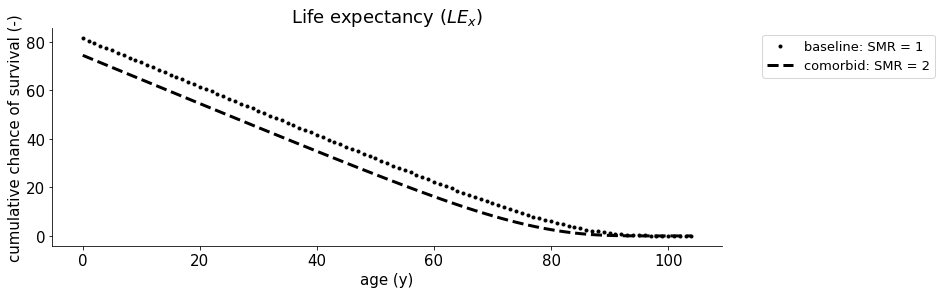

In [17]:
fig,ax = plt.subplots(figsize=(12,4))
SMR_comorbid=2
ax.set_title('Life expectancy ($LE_x$)')
ax.set_ylabel('cumulative chance of survival (-)')
ax.set_xlabel('age (y)')
ax.plot(QALY_model.life_expectancy(SMR=1),'.',color='black')
ax.plot(QALY_model.life_expectancy(SMR=SMR_comorbid),'--',color='black')
ax.legend(['baseline: SMR = 1', 'comorbid: SMR = '+ str(SMR_comorbid)], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.grid(False)

### Compute and visualize QALEs en QALYs of the comorbid population

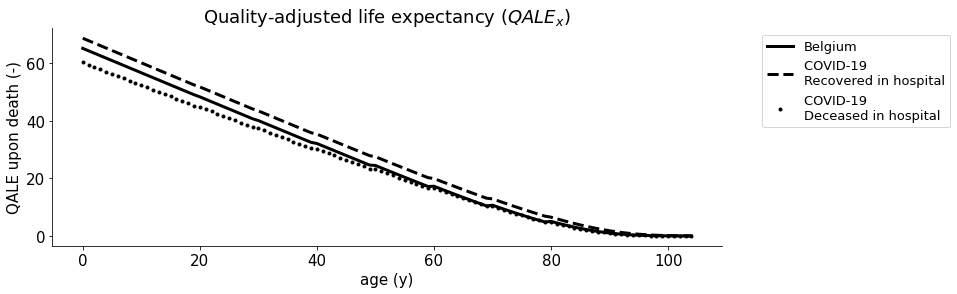

In [18]:
fig,ax = plt.subplots(figsize=(12,4))
SMR_method = 'convergent'
# No comorbidity
ax.plot(QALY_model.compute_QALE_x(population='Belgium', SMR_method='convergent'), color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALE_x(population='R', SMR_method='convergent'), '--',color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALE_x(population='D', SMR_method='convergent'), '.',color='black')
ax.set_xlabel('age (y)')
ax.set_ylabel('QALE upon death (-)')
ax.legend(['Belgium', 'COVID-19 \nRecovered in hospital','COVID-19 \nDeceased in hospital'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.set_title('Quality-adjusted life expectancy ($QALE_x$)')
ax.grid(False)

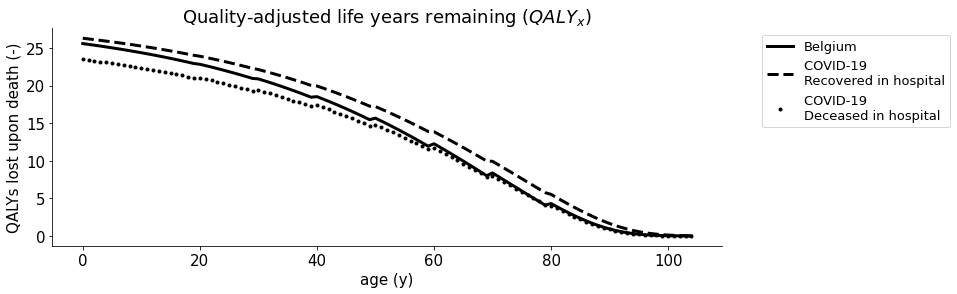

In [21]:
fig,ax = plt.subplots(figsize=(12,4))
SMR_method = 'convergent'
r=0.03
# No comorbidity
ax.plot(QALY_model.compute_QALY_x(population='Belgium', SMR_method=SMR_method,r=r), color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALY_x(population='R', SMR_method=SMR_method,r=r), '--',color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALY_x(population='D', SMR_method=SMR_method,r=r), '.',color='black')
ax.set_xlabel('age (y)')
ax.set_ylabel('QALYs lost upon death (-)')
ax.legend(['Belgium', 'COVID-19 \nRecovered in hospital','COVID-19 \nDeceased in hospital'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.set_title('Quality-adjusted life years remaining ($QALY_x$)')
ax.grid(False)

### Map QALYs to COVID-19 SEIQRD age-bins

In [27]:
# Manual approach
QALY_model.bin_QALY_x(QALY_model.compute_QALY_x(population='R', SMR_method='convergent',r=r))

age_group
0-9      25.852392
10-19    24.727979
20-29    23.209413
30-39    21.225042
40-59    18.775382
50-59    15.752291
60-69    12.127897
70-79     8.042550
80+       1.926611
dtype: float64

In [36]:
# Automatically loop over populations and make a pd.Dataframe
binned_QALY_df = QALY_model.build_binned_QALY_df()

### Perform the acute QALY calculation and add to the xarray output of the model

In [43]:
out = QALY_model.append_acute_QALY_losses(out, binned_QALY_df)

### Visualize number of QALYs lost

Text(0.5, 1.0, 'Acute QALY losses')

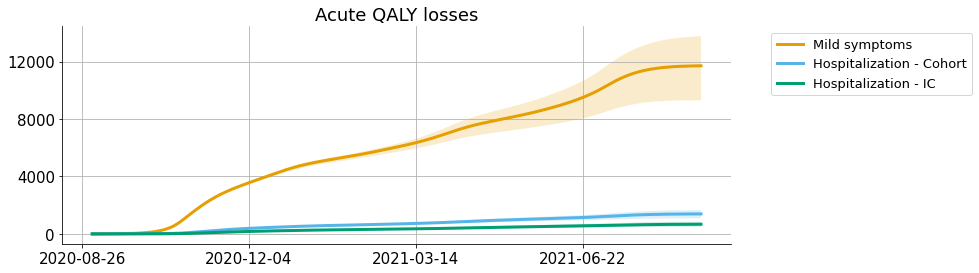

In [40]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(out['time'],out['QALYs_mild'].mean(dim='draws').cumsum().sum(dim='Nc'))
ax.fill_between(out['time'].values,out['QALYs_mild'].quantile(dim='draws',q=1-0.05/2).cumsum().sum(dim='Nc'),out['QALYs_mild'].quantile(dim='draws',q=0.05/2).cumsum().sum(dim='Nc'),alpha=0.2)
ax.plot(out['time'],out['QALYs_cohort'].mean(dim='draws').cumsum().sum(dim='Nc'))
ax.fill_between(out['time'].values,out['QALYs_cohort'].quantile(dim='draws',q=1-0.05/2).cumsum().sum(dim='Nc'),out['QALYs_cohort'].quantile(dim='draws',q=0.05/2).cumsum().sum(dim='Nc'),alpha=0.2)
ax.plot(out['time'],out['QALYs_ICU'].mean(dim='draws').cumsum().sum(dim='Nc'))
ax.fill_between(out['time'].values,out['QALYs_ICU'].quantile(dim='draws',q=1-0.05/2).cumsum().sum(dim='Nc'),out['QALYs_ICU'].quantile(dim='draws',q=0.05/2).cumsum().sum(dim='Nc'),alpha=0.2)
ax = _apply_tick_locator(ax)
ax.legend(['Mild symptoms', 'Hospitalization - Cohort', 'Hospitalization - IC'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.set_title('Acute QALY losses')

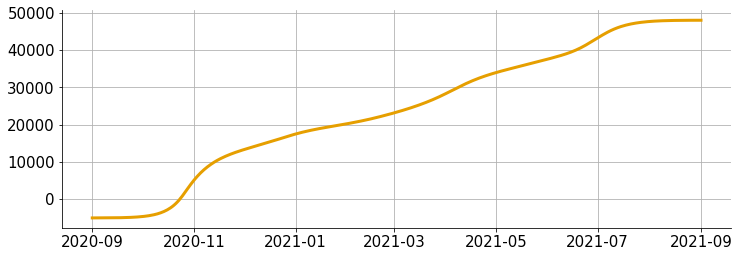

In [41]:
fig,ax = plt.subplots(figsize=(12,4))
#ax.plot(out['time'],out['QALYs_treatment'].mean(dim='draws').cumsum().sum(dim='Nc'))
#ax.plot(out['time'],out['QALYs_death'].mean(dim='draws').sum(dim='Nc'))
ax.plot(out['time'],out['H_in'].mean(dim='draws').sum(dim='Nc').cumsum() - out['D'].mean(dim='draws').sum(dim='Nc'))

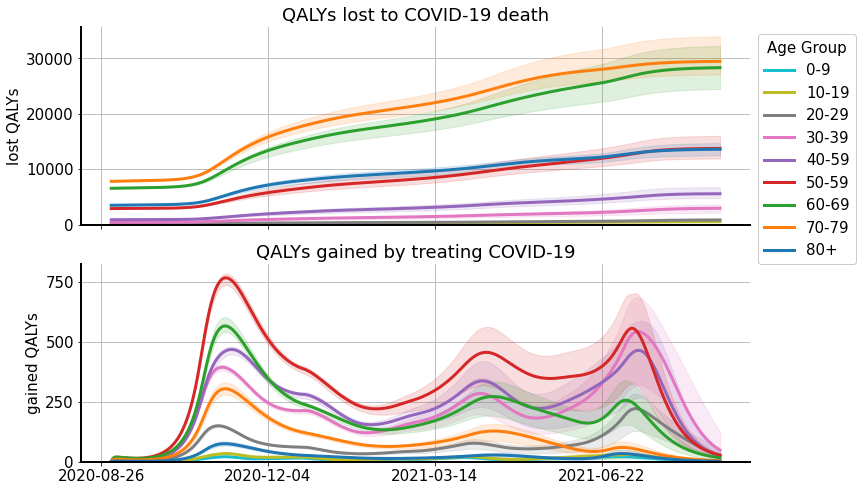

In [44]:
#Plot

Palette=cm.get_cmap('tab10_r', levels).colors
age_group=['0-9','10-19','20-29','30-39','40-59','50-59','60-69','70-79','80+']

fig, axs = plt.subplots(2,figsize=(12,8),sharex=True)

states = ['QALYs_death','QALYs_treatment']
title = ['QALYs lost to COVID-19 death', 'QALYs gained by treating COVID-19']
ylabel = ['lost QALYs','gained QALYs']

for j in range(len(states)):
    ax = axs[j]
    for i in range(levels):        
        ax.plot(simtime,out[states[j]].mean(dim="draws")[i],linewidth=3, label=age_group[i],color=Palette[i])
        ax.fill_between(simtime,out[states[j]].quantile(1-conf_int/2,dim="draws")[i],out[states[j]].quantile(conf_int/2,dim="draws")[i], alpha = 0.15, color=Palette[i])

    ax.set_title(title[j])
    ax.set_ylim(bottom=0)
    ax.set_ylabel(ylabel[j])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.set_axisbelow(True)
    if j == 0:
        ax.legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1))  
    # limit the number of ticks on the axis
    ax = _apply_tick_locator(ax)
   
# save figure
plt.savefig('../../results/QALYs/QALYs_gained_lost.jpg',bbox_inches='tight',dpi=300)

###  The effect of hospital care reduction vs. COVID-19
+ In the folowing example, the loss of life due to a constant average percentual reduction in regular hospital is calculated and compared with the overall loss of life to Covid-19.
+ The provided function can be used to investigate the effect of time-dependent changes in hospital care as well as reductions in the treatment of different disease categories.

In [ ]:
from covid19model.models.QALY import lost_QALYs_hospital_care

# Define percentual reduction range
reduction_range=np.linspace(0.10,0.99,100)
# Calculate QALYs lost due to hospital care reduction
lost_hospital=lost_QALYs_hospital_care(reduction_range)
# Calculate how much QALYs are lost over a time period delta_T
delta_T = (simtime[-1]-simtime[0])/pd.Timedelta(days=1)
QALY_indirect = lost_hospital*delta_T
# Extract direct QALY loss from model
QALY_direct_mean = np.cumsum(out['QALYs_treatment'].mean(dim="draws").sum(dim="Nc").values)[-1]
QALY_direct_lower = np.cumsum(out['QALYs_treatment'].quantile(conf_int/2,dim="draws").sum(dim="Nc").values)[-1]
QALY_direct_upper = np.cumsum(out['QALYs_treatment'].quantile(1-conf_int/2,dim="draws").sum(dim="Nc").values)[-1]
# Calculate ratio
ratio_mean = QALY_direct_mean/QALY_indirect
ratio_upper = QALY_direct_lower/QALY_indirect
ratio_lower = QALY_direct_upper/QALY_indirect
#ratio_data = sum(deaths*lost_QALY_pp)/QALY_indirect

In [ ]:
from covid19model.visualization.output import _apply_tick_locator

# Initialize plot
fig,ax = plt.subplots(figsize=(12,6))

# Add lines
ax.plot(reduction_range*100,np.ones(100),color='red',alpha=0.8,linewidth=2)
ax.plot(reduction_range*100,ratio_mean,'--',color='black')
ax.fill_between(reduction_range*100,ratio_lower,ratio_upper,alpha=0.2,color='black')

# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)

# labels and title
ax.set_xlabel('Reduction of hospital care (%)')
ax.set_ylabel('QALY ratio (direct/indirect)')
#plt.title('Comparison of qualitative life years lost\n directly vs. indirectly to SARS-CoV-2')

# save figure
plt.savefig('../../results/QALYs/QALY_ratio.pdf',dpi=300)